In [17]:
import pandas
import sklearn
import statsmodels
import warnings
warnings.filterwarnings(action='ignore')
print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


# STEP 1 : 시계열 데이터 준비
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
* 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
#time series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
...,...,...,...,...,...,...
2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.000000,35812268
2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.000000,31490096
2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.000000,16450920


# STEP 2 : 각종 전처리 수행
* 결측치 처리
* 로그 변환

보간 (Interpolation)을 활용한 결측치 대입
주요 Hyperparameter
methodstr, default linear Interpolation technique 지정

-linear: 색인을 무시하고 값을 동일한 간격으로 처리 (MultiIndexes에서 지원되는 유일한 방법)

time: 주어진 간격의 길이를 보간하기 위해 매일 더 높은 해상도 데이터를 처리

index, values: 인덱스의 실제 숫자 값을 사용

pad: 기존 값을 사용하여 NaN 채우기

nearest, zero, slinear, quadratic, cubic, spline, barycentric, polynomial: scipy.interpolate.interp1d로 전달. 이 방법은 색인의 숫자 값을 사용. polynomial과 spline 모두 순서 (int)도 지정해야합니다 (예 : df.interpolate (method='polynomial', order=5).

krogh, piecewise_polynomial, spline, pchip, akima: 비슷한 이름의 SciPy 보간 방법을 둘러싼 Wrapper.

from_derivatives: scipy 0.18의 piecewise_polynomial보간 방법을 대체하는 scipy.interpolate.BPoly.from_derivatives를 참조

axis{0 or index, 1 or columns, None}, default None 보간할 축 설정

limitint, optional 채울 최대 연속 NaN 갯수. 0보다 커야함.

inplacebool, default False 데이터 업데이트 (if possible)

limit_direction{forward, backward, both}, default forward limit이 지정되면, 연속 NaN이 지정된 방향으로 채워집니다.

limit_area{None, inside, outside}, default None limit이 지정되면, 연속된 NaN은 지정된 제한(restriction)으로 채워집니다.

None: No fill restriction.

inside: 유효한 값으로 둘러싸인 NaN 만 채 웁니다 (보간).

outside: 유효 값을 초과하는 NaN 만 채 웁니다 (외삽).

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [5]:
# 로그 변환
ts_log = np.log(ts)

# STEP 3 : 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

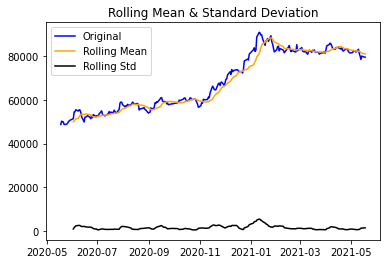

In [7]:
# 일정 시간 내 구간 통계치(Rolling Statistics) 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
plot_rolling_statistics(ts, window=12)

겹치는 데이터일수록 안정성이 높다고 알려주셨다!

In [8]:
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


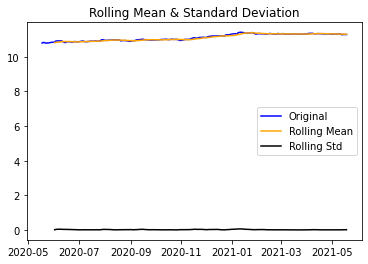

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


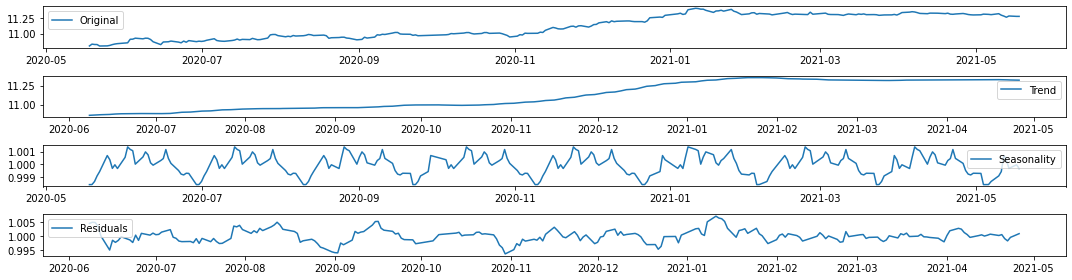

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(15, 4))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


p-value가 0.02를 훨씬 뛰어넘으므로, 안정성이 없다고 볼수있다.

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


p-value의 값은 0.00000006234854 이므로 안정성이 높은것을 확인했다.

test-statistic 이

critical value보다 낮아야

정상시계열이라고 판단하는 방식도 있다.

# STEP 4 : 학습, 테스트 데이터셋 생성
* 학습, 테스트 데이터셋 분리

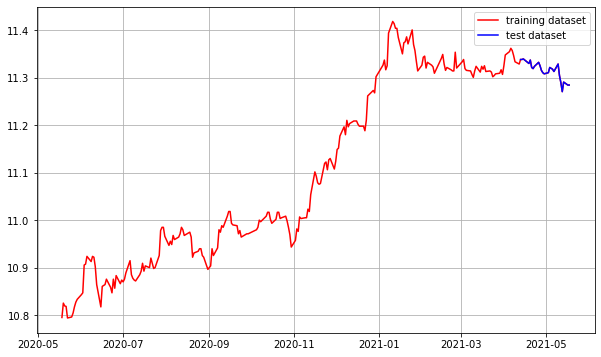

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

(ACF,d,pacf) (p,d,q)를 구하는것이다. 

<Figure size 2160x1080 with 0 Axes>

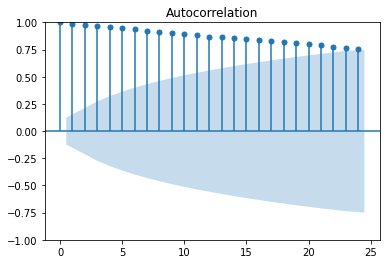

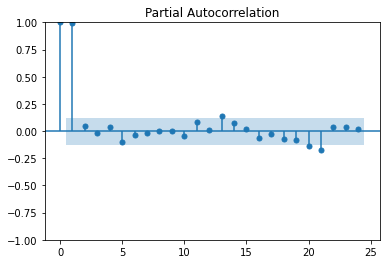

In [12]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(30, 15))
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

위 그래프 결과로

PACF그래프를 보면 p=1이 적합한 것 같다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻이다.
ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있다. q에 대해서는 적합한 값이 없어 보인다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다. 하지만 q를 바꿔가면서 확인해보는 것도 좋다.

In [15]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


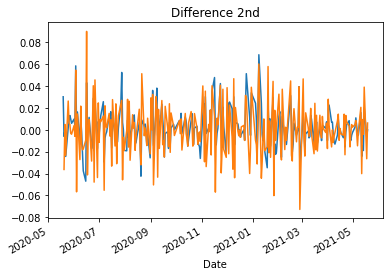

In [13]:

# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)



지수 확인으로 봤을때는 1차 차분이 더욱 안정적인것을 볼수있다.

주황색이 두번째 차분이다. 3번하면 오버피팅된다고 조원분께서 알려주셨다.

모수 p, q, d
ARIMA를 활용해서 시계열데이터 예측을 하려면 ARIMA의 모수를 데이터에 맞게 잘 설정해줘야한다.

* p : 자기회귀 모형(AR)의 시차
* q : 이동평균 모형(MA)의 시차
* d : 차분(diffdrence) 횟수

통상적으로 p + q < 2, p * q = 0 인 값들을 사용한다. 이는 p 나 q 중 하나의 값이 0이라는 뜻이다. 이렇게 하는 이유는 실제로 대부분의 시계열 데이터는 자기회귀 모형(AR)이나 이동평균 모형(MA) 중 하나의 경향만을 강하게 띠기 때문이다.

MA는 시계열의 Trend에 해당하는 부분을 모델링한다고 볼 수 있습니다.

ACF	PACF

AR(p)->	ACF plot이 서서히 감소하는 형태	PACF plot이 p lag 이후 절단되는 형태

MA(q)->	ACF plot이 q lag 이후 절단되는 형태 	PACF plot이 서서히 감소하는 형태

# STEP 6 : ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [60]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 15))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(1, 1, 15)   Log Likelihood                 588.759
Date:                Fri, 06 Jan 2023   AIC                          -1143.519
Time:                        01:57:26   BIC                          -1085.521
Sample:                             0   HQIC                         -1120.108
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1931      0.927      0.208      0.835      -1.623       2.010
ma.L1         -0.1473      0.927     -0.159      0.874      -1.964       1.669
ma.L2         -0.0216      0.082     -0.264      0.7

차분이 0 일때는 p-value값이 0.5가되므로 바꿔야한다.

1일때 lag use가 0 이므로 1을쓴다. 나머지는 직접넣어본다.

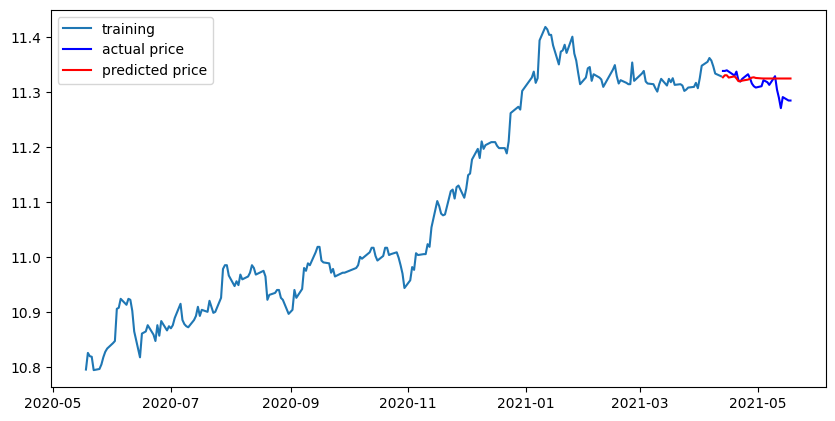

In [61]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


(1,1,1) 이었을때 그래프는 예측값이 현실적으로 불가능한 값을 띄고있었다.

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2823070.223485734
MAE:  1232.9865959246217
RMSE:  1680.1994594350201
MAPE: 1.52%


MSE:  1048973.6014239907

MAE:  843.7579531508708

RMSE:  1024.19412292006

MAPE: 1.03%

(2,0,1) 이었을때의 값이다.

MSE:  1057119.8161340475

MAE:  850.8270312480739

RMSE:  1028.1633217218202

MAPE: 1.04%

(1,0,1) 이었을때의 값일때 예측력이 늘어나지만, 오차가 늘어나는걸 보았다.

* 오히려 2,0,1 이었을떄 좀더 낮은 오차가 있었지만, 1,0,1 이었을때 좀더 유의미한 값이 나오기 때문에 1,0,1을 쓰는게 나을것같다.
* 하지만 차분 0 일때는 정상적 시계열이 아니기 때문에 차분을 1로둬야한다.
* 평균 절대 비율 오차의 값은 낮을수록 좋다는걸 알아냈다.
* 그래프로 봤을때 수동으로 정해줘야한다는걸 알았다.

# STEP 7 : 다른 주식 종목 예측해 보기
* 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기
* 테슬라를 해보자.
* 마이크로소프트를 해보자.

In [63]:
#테슬라time series 생성
dataset_filepath1 = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df1 = pd.read_csv(dataset_filepath1, index_col='Date', parse_dates=True)
ts1 = df1['Close']

ts1.head()

Date
2022-01-04    383.196655
2022-01-05    362.706665
2022-01-06    354.899994
2022-01-07    342.320007
2022-01-10    352.706665
Name: Close, dtype: float64

In [64]:
#마소time series 생성
dataset_filepath2 = os.getenv('HOME') + '/aiffel/stock_prediction/data/MSFT.csv'
df2 = pd.read_csv(dataset_filepath2, index_col='Date', parse_dates=True)
ts2 = df2['Close']

ts2.head()

Date
2022-01-04    329.010010
2022-01-05    316.380005
2022-01-06    313.880005
2022-01-07    314.040009
2022-01-10    314.269989
Name: Close, dtype: float64

In [65]:
df1

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,396.516663,402.666656,374.350006,383.196655,383.196655,100248300
2022-01-05,382.216675,390.113342,360.336670,362.706665,362.706665,80119800
2022-01-06,359.000000,362.666656,340.166656,354.899994,354.899994,90336600
2022-01-07,360.123322,360.309998,336.666656,342.320007,342.320007,84164700
2022-01-10,333.333344,353.033325,326.666656,352.706665,352.706665,91815000
...,...,...,...,...,...,...
2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500
2022-12-29,120.389999,123.570000,117.500000,121.820000,121.820000,221923300
2022-12-30,119.949997,124.480003,119.750000,123.180000,123.180000,157304500


In [66]:
# 테슬라결측치 처리
ts1 = ts1.interpolate(method='time')
ts1[ts1.isna()] 

Series([], Name: Close, dtype: float64)

In [67]:
# 마소결측치 처리
ts2 = ts2.interpolate(method='time')
ts2[ts2.isna()] 

Series([], Name: Close, dtype: float64)

In [68]:
# 로그 변환
ts1_log = np.log(ts1)

In [69]:
# 로그 변환
ts2_log = np.log(ts2)

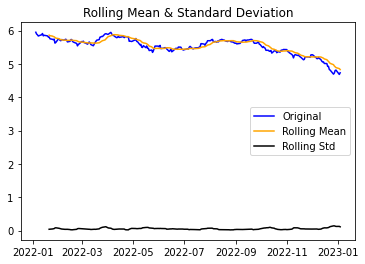

Results of Dickey-Fuller Test:
Test Statistic                  -0.068969
p-value                          0.952443
#Lags Used                       9.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


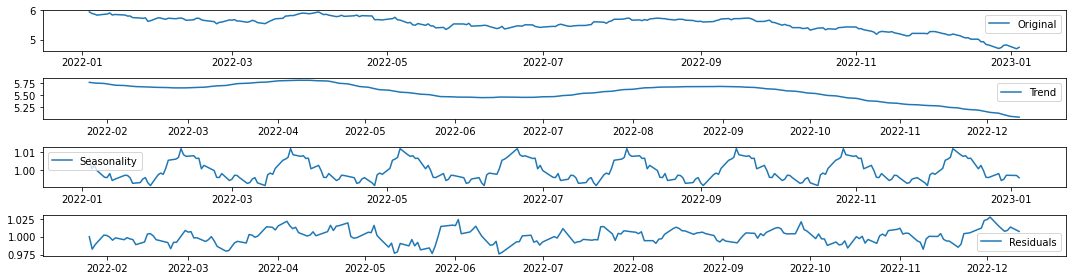

In [70]:
# 정성적 그래프 분석
plot_rolling_statistics(ts1_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts1_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(15, 4))
plt.subplot(411)
plt.plot(ts1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

p-value가 너무많다. 안정성이없다.

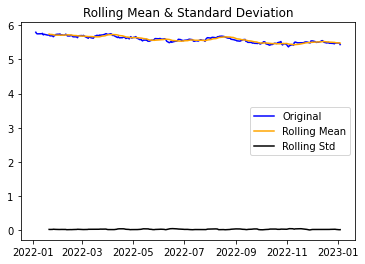

Results of Dickey-Fuller Test:
Test Statistic                  -2.180374
p-value                          0.213446
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


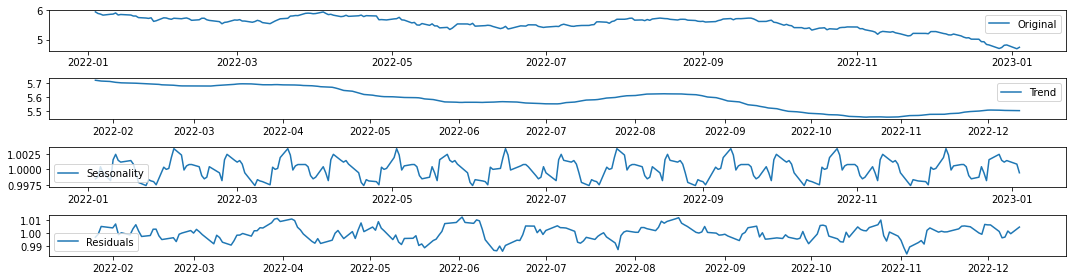

In [71]:
# 정성적 그래프 분석
plot_rolling_statistics(ts2_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts2_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(15, 4))
plt.subplot(411)
plt.plot(ts1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [72]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.948448e+00
p-value                        2.175856e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


In [73]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.948448e+00
p-value                        2.175856e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


안정성이 높게 나타났다.

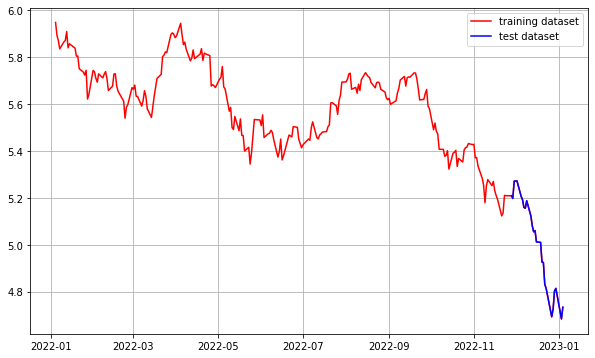

In [74]:
train_data1, test_data1 = ts1_log[:int(len(ts1_log)*0.9)], ts1_log[int(len(ts1_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts1_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data1, c='b', label='test dataset')
plt.legend()

테스트로 보면...엄청난 몰락이다

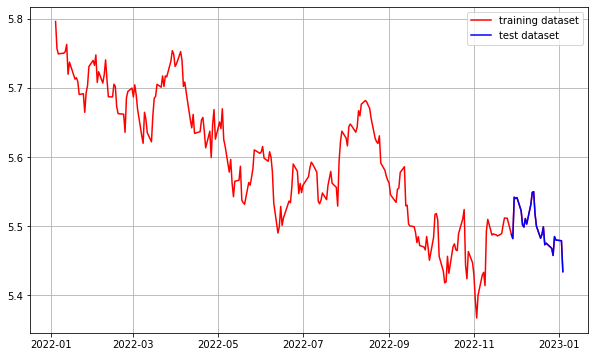

In [75]:
#마소의 그래프
train_data2, test_data2 = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data2, c='b', label='test dataset')
plt.legend()

<Figure size 2160x1080 with 0 Axes>

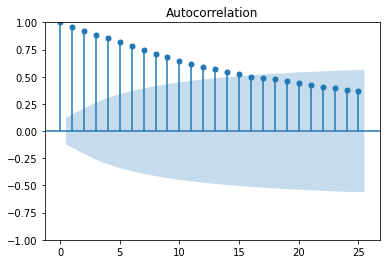

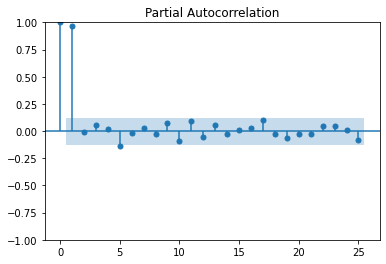

In [76]:
plt.figure(figsize=(30, 15))
plot_acf(ts1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

테슬라또한 거의 비슷한값이 나왔다.

<Figure size 2160x1080 with 0 Axes>

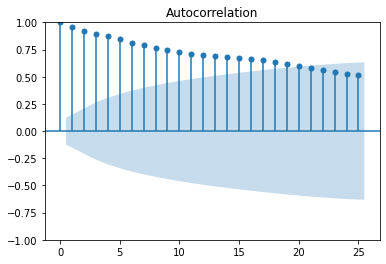

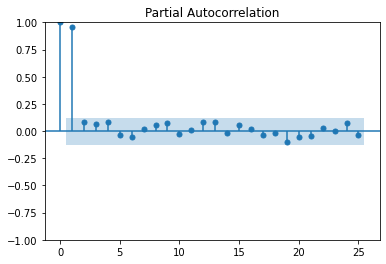

In [77]:
plt.figure(figsize=(30, 15))
plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -3.994499
p-value                          0.001440
#Lags Used                       8.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.128910e+01
p-value                        1.394088e-20
#Lags Used                     7.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


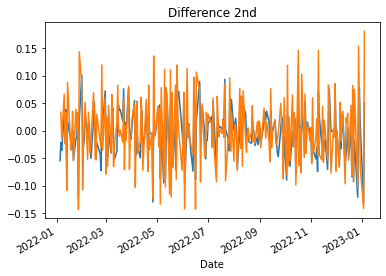

In [78]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_12 = ts1_log.diff(periods=1).iloc[1:]
diff_12.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_12)
# 혹시 필요한 경우 2차 차분 구하기
diff_22 = diff_12.diff(periods=1).iloc[1:]
diff_22.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_22)
# 3차차분구하기
# diff_33 = diff_22.diff(periods=1).iloc[1:]
# diff_33.plot(title='Difference 3rd')

# augmented_dickey_fuller_test(diff_33)
# 3차차분은 오버피팅에 걸린다.

2차 차분시 엄청난 안정성을 가졌다.

Results of Dickey-Fuller Test:
Test Statistic                  -3.994499
p-value                          0.001440
#Lags Used                       8.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.128910e+01
p-value                        1.394088e-20
#Lags Used                     7.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


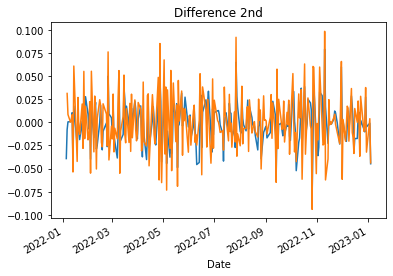

In [79]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_121 = ts2_log.diff(periods=1).iloc[1:]
diff_121.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_12)
# 혹시 필요한 경우 2차 차분 구하기
diff_222 = diff_121.diff(periods=1).iloc[1:]
diff_222.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_22)

In [93]:
# Build Model
# Build and Train  Model
model = ARIMA(train_data1, order=(1, 2, 15))  
fitted_m1 = model.fit() 

print(fitted_m1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(1, 2, 15)   Log Likelihood                 409.595
Date:                Fri, 06 Jan 2023   AIC                           -785.190
Time:                        02:05:04   BIC                           -727.192
Sample:                             0   HQIC                          -761.779
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7095      0.481     -1.475      0.140      -1.652       0.233
ma.L1         -0.2744      0.489     -0.561      0.575      -1.234       0.685
ma.L2         -0.6892      0.464     -1.486      0.1

In [92]:
# Build Model
# Build and Train  Model
model = ARIMA(train_data2, order=(0, 2, 2))  
fitted_m2 = model.fit() 

print(fitted_m2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(0, 2, 2)   Log Likelihood                 528.793
Date:                Fri, 06 Jan 2023   AIC                          -1051.585
Time:                        02:04:57   BIC                          -1041.351
Sample:                             0   HQIC                         -1047.454
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0303      1.254     -0.822      0.411      -3.488       1.427
ma.L2          0.0306      0.075      0.409      0.682      -0.116       0.177
sigma2         0.0005      0.001      0.788      0.4

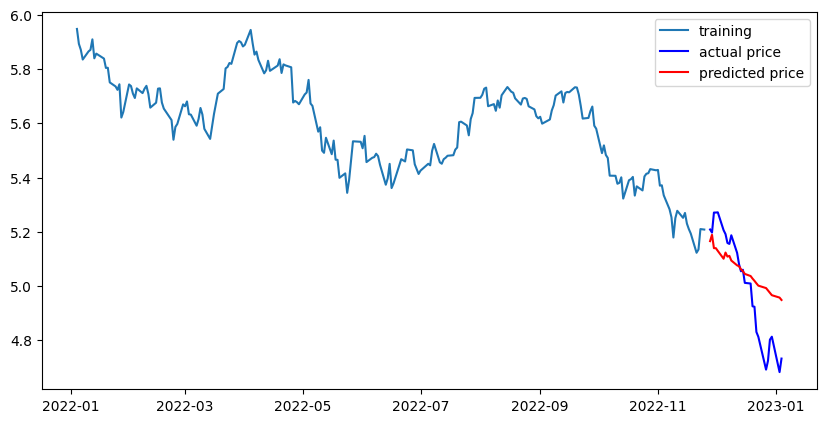

In [94]:
# Forecast : 결과가 fc에 담깁니다. 
fc1 = fitted_m1.forecast(len(test_data1), alpha=0.05)  # 95% conf
fc1 = np.array(fc1)
# Make as pandas series
fc_series1 = pd.Series(fc1, index=test_data1.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data1, label='training')
plt.plot(test_data1, c='b', label='actual price')
plt.plot(fc_series1, c='r',label='predicted price')
plt.legend()
plt.show()

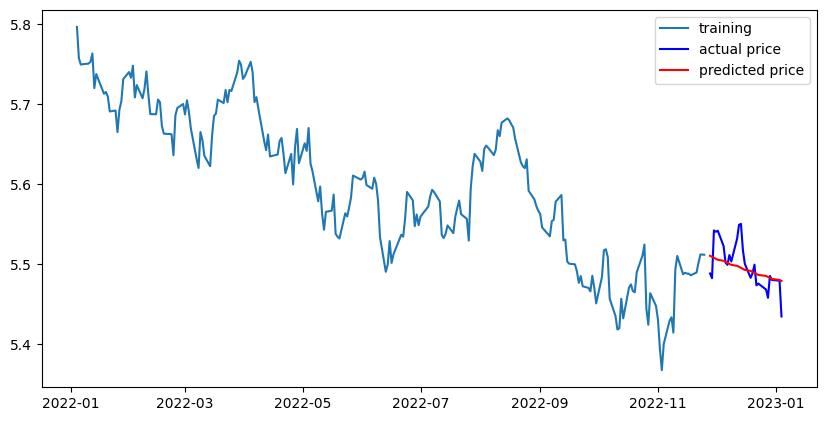

In [95]:
# Forecast : 결과가 fc에 담깁니다. 
fc2 = fitted_m2.forecast(len(test_data2), alpha=0.05)  # 95% conf
fc2 = np.array(fc2)
# Make as pandas series
fc_series2 = pd.Series(fc2, index=test_data2.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data2, label='training')
plt.plot(test_data2, c='b', label='actual price')
plt.plot(fc_series2, c='r',label='predicted price')
plt.legend()
plt.show()

In [97]:
# 테슬라의 오차값
mse1 = mean_squared_error(np.exp(test_data1), np.exp(fc1))
print('MSE: ', mse1)

mae1 = mean_absolute_error(np.exp(test_data1), np.exp(fc1))
print('MAE: ', mae1)

rmse1 = math.sqrt(mean_squared_error(np.exp(test_data1), np.exp(fc1)))
print('RMSE: ', rmse1)

mape1 = np.mean(np.abs(np.exp(fc1) - np.exp(test_data1))/np.abs(np.exp(test_data1)))
print('MAPE: {:.2f}%'.format(mape1*100))

MSE:  382.57633305642327
MAE:  16.16451731344137
RMSE:  19.55955861098157
MAPE: 11.82%


최종 예측 모델 정확도 측정을 낮게 잡혔다. q가 아마 acf에 유의미한값을가지는것같다. q가 16을 넘어가자, 오차율이 확연하게 늘었다.

In [96]:
# 마소의 오차값
mse2 = mean_squared_error(np.exp(test_data2), np.exp(fc2))
print('MSE: ', mse1)

mae2 = mean_absolute_error(np.exp(test_data2), np.exp(fc2))
print('MAE: ', mae1)

rmse2 = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(fc2)))
print('RMSE: ', rmse1)

mape2 = np.mean(np.abs(np.exp(fc2) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MAPE: {:.2f}%'.format(mape2*100))

MSE:  1446.9067865778254
MAE:  29.844724885448446
RMSE:  38.03822796316655
MAPE: 1.91%


# 회고
* 모수의 값들을 찾는 방법에 대해 이해한것같다.
* 여러개의 주식을 보니, 수동으로 찾는 방법이 제일 좋은것 같다.

마크다운으로 내가 이해한 값들을 써보았다. MSE, MAE, RMSE, MAPE는 낮아야 좋은 모델이라고 이해했다.
또한, adfuller 등의 그래프들을 만들었을때, 겹치는 데이터가 많을수록 좋은 데이터라고 알았다.
이런것들을 외우지는 못하겠지만, 깃허브를 보며, 다시 기억을 떠올리기를 빈다.

또한 acf 와 pacf로 유의미한 값, 모수를 찾는것에대해 이해한것같다. 수동으로 찾아야 제일 좋은값을 발견해낼수있다.
내가 이해한바와는 다르게, 나온것이 좀 당황스러웠다. 이런것들이 주식에 진짜 모델에 쓰일정도는 아닌것같다.
오히려 diff p-value값이 더 높게나온것이 정확도가높은것이있었다.

diff도 오히려 차수의 p-value 값이 높게 나온것이 정확도가 높았다. 그냥..수동으로해야 잘맞는것같다.

질문을 해보니 p-value의 값이 0.02가 되기만해도 된다는것을 알려주셨다.

차수가 3회이상이 된다면 오버피팅이 된다고 알려주셨다.

test-statistic 이

critical value보다 낮아야

정상시계열이라고 판단하는 방식도 있다고 알려주셨다.

* test-statistic 이 지수표현식에서 더낮을줄알았는데 오히려 높은경우도 있었다.